# Data Processing

In [26]:
from statistics import median
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib as mpl
import seaborn as sb

feature_list_xlsx = ["CZA","CZB","CZD","CZH","CZM","CZV","PMC","TRF"]
feature_list_csv = ["EDU","MHI","new_housing","Public_Assistance_Rate","median_gross_rent","median_monthly_housing_costs",
"perc_below_poverty", "perc_college_grad","perc_hs_grad","perc_insured","perc_rental_housing","unemployment","vacancies","work_travel_time"]
path = os.path.join(os.getcwd(),'data_clean')
feature_values = pd.read_excel(os.path.join(path,'TRF_2016.xlsx'))
geoid = feature_values['GEOID']
dataframes = {}

# Read in feature values
for year in [2016,2019]:
    df_dict = {}
    df_dict['GEOID'] = geoid
    for feature in feature_list_xlsx:
        file_name = feature + "_" + str(year) + '.xlsx'
        feature_values = pd.read_excel(os.path.join(path,file_name))
        df_dict[feature] = feature_values[file_name[:-5]]
    for feature in feature_list_csv:
        file_name = feature + "_" + str(year) + '.csv'
        feature_values = pd.read_csv(os.path.join(path,file_name))
        df_dict[feature] = feature_values[file_name[:-4]]
    dataframes[year] = pd.DataFrame(df_dict)
    dataframes[year] = dataframes[year].apply(pd.to_numeric, errors='coerce')
    #very_small_number = 0.00000000001 # to avoid inf in calculating ratio below
    #dataframes[year].replace(0,very_small_number,inplace=True)
    
# Find change in X
feature_list = feature_list_xlsx + feature_list_csv
X_values = dataframes[2016].copy()
for feature in feature_list:
    X_values[feature] = (dataframes[2019])[feature] - (dataframes[2016])[feature]

# Read in house values
house_values = pd.read_csv(os.path.join(path,'home_value.csv'))
renamed_geoid = []
for row in house_values['GEOID']:
    tract_num = (row.split(',')[0]).replace("Census Tract ",'')
    if ('.' in tract_num):
        if len(tract_num) == 6:
            tract_num = '0' + tract_num
        tract_num = '17031' + tract_num.replace('.','')
    else:
        if len(tract_num) == 3:
            tract_num = '0' + tract_num
        tract_num = '17031' + tract_num + '00'
    renamed_geoid.append(int(tract_num))

house_values['GEOID'] = renamed_geoid
house_values_2016 = house_values[house_values['YEAR'] == 2016]
house_values_2016 = house_values_2016.rename(columns = {"house_value": "house_value_2016"})
house_values_2019 = house_values[house_values['YEAR'] == 2019]
house_values_2019 = house_values_2019.rename(columns = {"house_value": "house_value_2019"})

y_labels = pd.merge(house_values_2016, house_values_2019, on = ['GEOID'])
y_labels['house_val_change'] = y_labels["house_value_2019"] / y_labels["house_value_2016"]
y_labels = y_labels[['GEOID','house_val_change']]

# Create dataframe of feature and outcome values
df = pd.merge(y_labels, X_values, on=['GEOID'])
col_dict = {'CZA': 'violent_crime',"CZB":"burglary","CZD":"drug_abuse",'CZH': 'aggravated_assault', "CZM": "major_crime", 
'CZV': 'homicide',"PMC":"pollution", 'TRF': 'traffic_intensity', 'EDU': 'college_enrolled','MHI': 'household_income', 
"Public_Assistance_Rate":"public_assistance","vacancies":"housing_vacancies"}

feature_list = col_dict.values()
# feature_list = feature_list_xlsx + feature_list_csv

df = df.rename(columns = col_dict)
print(df)

           GEOID  house_val_change  violent_crime  burglary  drug_abuse  \
0    17031010100          1.095795           -1.0       9.0        26.0   
1    17031010201          1.123097           -5.0      -3.0        -6.0   
2    17031010202          1.314329            3.0       3.0         4.0   
3    17031010300          1.002115            3.0       7.0         1.0   
4    17031010400          1.008364           -9.0     -18.0         0.0   
..           ...               ...            ...       ...         ...   
773  17031843500          1.425040            8.0      -7.0         1.0   
774  17031843600          1.005660           -1.0      -8.0       -10.0   
775  17031843700          1.129010          -10.0       0.0      -163.0   
776  17031843800          0.996522           10.0       2.0        -7.0   
777  17031843900          0.937888            0.0       0.0       106.0   

     aggravated_assault  major_crime  homicide  pollution  traffic_intensity  \
0                  

# Summary Statistics

In [27]:
df = df.drop('GEOID',1)
print(df.head())
print(df.describe())
print(df.dtypes)

   house_val_change  violent_crime  burglary  drug_abuse  aggravated_assault  \
0          1.095795           -1.0       9.0        26.0                 1.0   
1          1.123097           -5.0      -3.0        -6.0                -2.0   
2          1.314329            3.0       3.0         4.0                 1.0   
3          1.002115            3.0       7.0         1.0                 0.0   
4          1.008364           -9.0     -18.0         0.0                -1.0   

   major_crime  homicide  pollution  traffic_intensity  college_enrolled  ...  \
0         34.0      -1.0  -2.069161         237.788368               1.7  ...   
1         17.0     -11.0  -2.082873         287.795388              -2.4  ...   
2         86.0      -6.0  -2.092997         197.613229              -8.0  ...   
3         45.0       2.0  -2.093499         258.007988               3.7  ...   
4        -45.0     -15.0  -2.094886         810.415832               3.1  ...   

   median_gross_rent  median_mon

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [28]:
print(df.dtypes)

house_val_change                float64
violent_crime                   float64
burglary                        float64
drug_abuse                      float64
aggravated_assault              float64
major_crime                     float64
homicide                        float64
pollution                       float64
traffic_intensity               float64
college_enrolled                float64
household_income                float64
new_housing                     float64
public_assistance               float64
median_gross_rent               float64
median_monthly_housing_costs    float64
perc_below_poverty              float64
perc_college_grad               float64
perc_hs_grad                    float64
perc_insured                    float64
perc_rental_housing             float64
unemployment                    float64
housing_vacancies               float64
work_travel_time                float64
dtype: object


The dataframe comprises 2557 observations, where each observation contains the median house value (outcome variable) and 9 feature variables for a given census tract and year. The variables will be split 80:20, so that 80% of the data is in the training dataset and 20% is in the testing dataset.

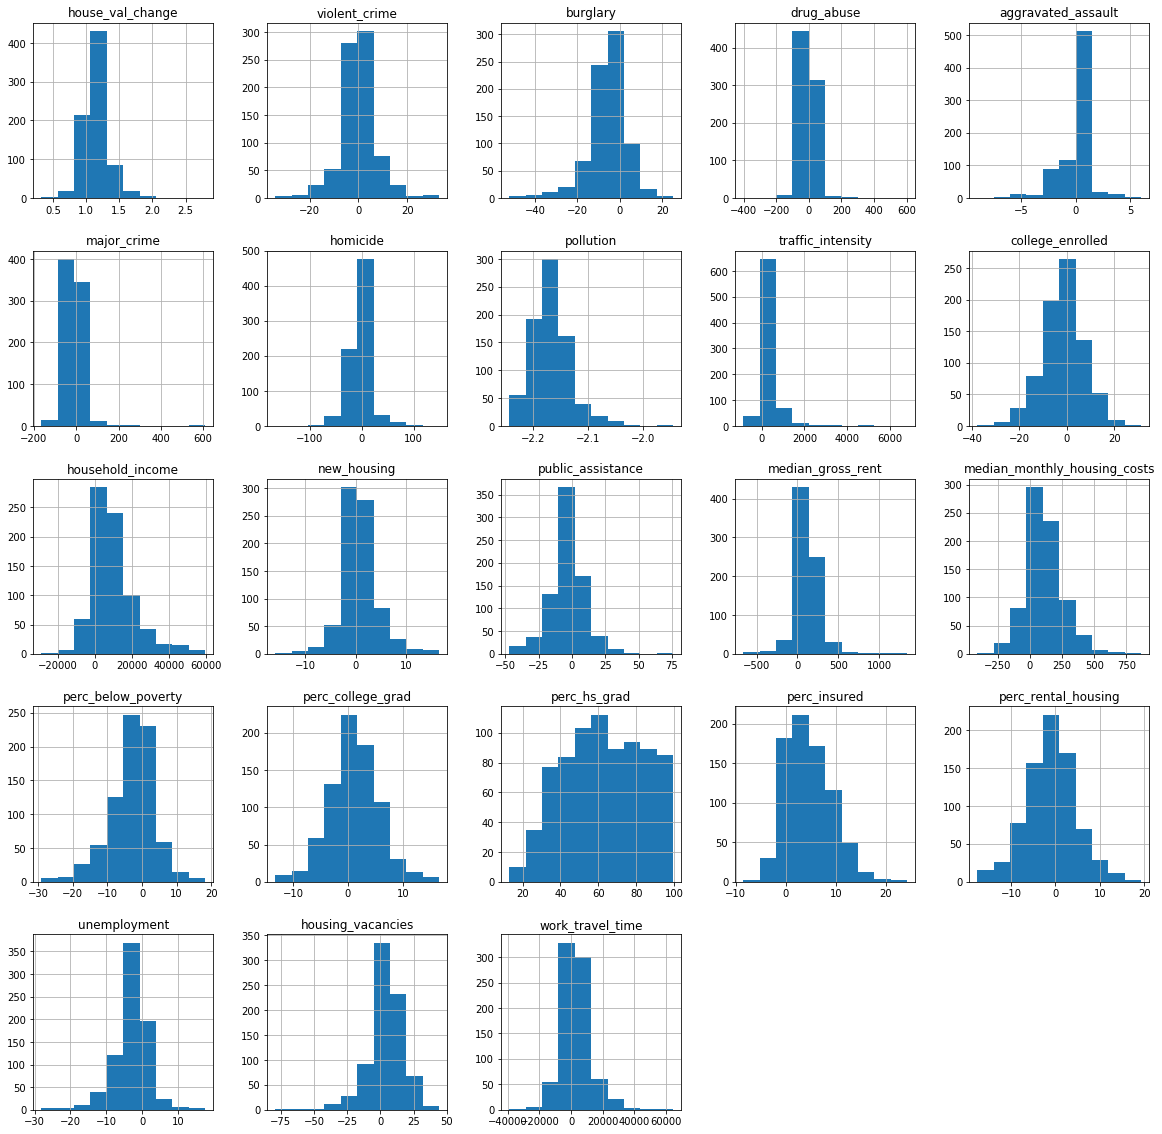

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

df.hist(figsize=(20,20))
plt.show()

From plotting the distribution of the feature values, we observe that features vary significantly in scale, so we will be normalizing the feature parameters. We can also observe that features such as assault and traffic instensity are significantly skewed with most values being in the lowest value bucket, as such, we have concerns that there may no be enough variation in those features to be valuable for the model. We fortunately do not observe any outliers that would need to be excluded.

house_val_change                1.000000
median_monthly_housing_costs    0.115615
household_income                0.098760
new_housing                     0.086353
perc_college_grad               0.065936
unemployment                    0.055948
traffic_intensity               0.053241
college_enrolled                0.032773
perc_hs_grad                    0.026706
perc_insured                    0.026599
work_travel_time                0.026477
median_gross_rent               0.013971
aggravated_assault             -0.005396
burglary                       -0.023391
homicide                       -0.028656
housing_vacancies              -0.037721
major_crime                    -0.037850
drug_abuse                     -0.038299
violent_crime                  -0.051905
pollution                      -0.059911
perc_rental_housing            -0.102555
public_assistance              -0.105758
perc_below_poverty             -0.107600
Name: house_val_change, dtype: float64


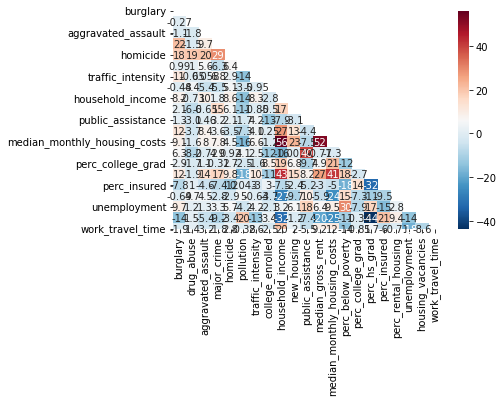

In [30]:
corr_matrix = df.corr()
print(corr_matrix["house_val_change"].sort_values(ascending=False))
mask = np.zeros_like(df.iloc[:,2:].corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(df.iloc[:,2:].corr()*100, cmap='RdBu_r', annot = True, mask=mask)

Based on the heat map of the correlations of features, we can see that there is a positive correlation between housing price and median household income for an area, as well as the percent of the population enrolled in college. We can also observe a strong negative correlation between household price and unemployment levels and crime levels in the area. There is strong correlation between the crime features, which my make it worth combining them into a single feature.

# Feature Engineering

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X = df.drop('house_val_change', 1)
y = df['house_val_change']

imputer = SimpleImputer(strategy="median")

# Replace NA feature values with feature median
for feature in feature_list:
    col_ave = X[feature].median()
    X[feature].fillna(value = col_ave, inplace = True)

# Attempted combining variables, but models did not change from collapsing crime measures, and deterioriated from collapsing crime and poverty measures
# Collapse crime and poverty measures into one variable each
# X['crime_rate'] = X['violent_crime'] + X['aggravated_assault'] + X['homicide']
# X = X.drop(['violent_crime','aggravated_assault','homicide'],1)

# X['poverty_index'] = X['poverty_rate'] + X['rental_rate'] + X['unemploy_rate']
# X = X.drop(['poverty_rate','rental_rate','unemploy_rate'],1)

#feature_list = ['traffic_intensity', 'college_rate','household_income','poverty_rate','rental_rate','unemploy_rate','crime_rate']

# Scale all features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
X_trans = (num_pipeline.fit_transform(X))

train_x, test_x, train_y, test_y = train_test_split(X_trans, y.to_numpy(), test_size=0.2, random_state=123)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


# Model Training

### Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)
lin_predictions = lin_reg.predict(train_x) 
lin_mse = mean_squared_error(train_y, lin_predictions)  
lin_rmse = np.sqrt(lin_mse) 
print(lin_rmse)
#print(mean_absolute_error(train_y, lin_predictions))

# Cross validation
lin_scores = cross_val_score(lin_reg, train_x, train_y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

0.19609134719517363
Scores: [0.19440393 0.17794487 0.17063749 0.19566139 0.14550326 0.18501246
 0.28669546 0.27966392 0.20366733 0.18311414]
Mean: 0.20223042219468385
Standard deviation: 0.043248724872345726


### Decision Trees

In [33]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=123)
tree_reg.fit(train_x, train_y)
dt_predictions = tree_reg.predict(train_x)
scores = cross_val_score(tree_reg, train_x, train_y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [0.26617438 0.34371124 0.24987964 0.28843847 0.2749241  0.20197334
 0.36668765 0.35623722 0.26707483 0.25827935]
Mean: 0.2873380233435069
Standard deviation: 0.04976934788721868


### Support Vector Machine

In [34]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(train_x, train_y)
svm_predictions = svm_reg.predict(train_x)
svm_mse = mean_squared_error(train_y, svm_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

0.1999290989740013

### Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=123)
forest_reg.fit(train_x, train_y)
rf_predictions = forest_reg.predict(train_x) 
forest_mse = mean_squared_error(train_y, rf_predictions) 
forest_rmse = np.sqrt(forest_mse) 
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, train_x, train_y,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

0.07896001083368902
Scores: [0.18892562 0.21858296 0.16820794 0.19852747 0.14782835 0.19053214
 0.28438234 0.2883419  0.19783734 0.17510803]
Mean: 0.20582740872815802
Standard deviation: 0.04416080134757107


### Gradient Boosted Trees

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

boosted_reg = GradientBoostingRegressor(n_estimators=100, random_state=123)
boosted_reg.fit(train_x, train_y)
boosted_predictions = boosted_reg.predict(train_x) 
boosted_mse = mean_squared_error(train_y, boosted_predictions) 
boosted_rmse = np.sqrt(boosted_mse) 
print(boosted_rmse)

boosted_scores = cross_val_score(boosted_reg, train_x, train_y,scoring="neg_mean_squared_error", cv=10)
boosted_rmse_scores = np.sqrt(-boosted_scores)
display_scores(boosted_rmse_scores)

0.1102835078868655
Scores: [0.19855691 0.25434046 0.19756134 0.21396926 0.17871883 0.19211035
 0.29030044 0.29903667 0.20925828 0.17881489]
Mean: 0.22126674424413834
Standard deviation: 0.04200643086689235


# Fine Tuning Model Using Grid Search

In [37]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [5, 10, 50, 100], 'max_features': [2, 8, 10]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [5, 10, 50, 100], 'max_features': [2, 8, 10]},
  ]
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_x, train_y)
print(grid_search.best_params_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

feature_importances = grid_search.best_estimator_.feature_importances_
#print(sorted(zip(feature_importances, ['YEAR'] + feature_list_xlsx + feature_list_csv), reverse=True))


{'max_features': 2, 'n_estimators': 100}
0.22619749105127984 {'max_features': 2, 'n_estimators': 5}
0.21669497529392454 {'max_features': 2, 'n_estimators': 10}
0.20796469831078787 {'max_features': 2, 'n_estimators': 50}
0.2065248018670672 {'max_features': 2, 'n_estimators': 100}
0.2265302855176264 {'max_features': 8, 'n_estimators': 5}
0.21696981362040038 {'max_features': 8, 'n_estimators': 10}
0.20943429950404108 {'max_features': 8, 'n_estimators': 50}
0.20804957724553924 {'max_features': 8, 'n_estimators': 100}
0.2245873161236702 {'max_features': 10, 'n_estimators': 5}
0.21782876290141237 {'max_features': 10, 'n_estimators': 10}
0.21190336985127844 {'max_features': 10, 'n_estimators': 50}
0.21066278114554515 {'max_features': 10, 'n_estimators': 100}
0.2304185311022084 {'bootstrap': False, 'max_features': 2, 'n_estimators': 5}
0.22007838968616902 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.21026389741293625 {'bootstrap': False, 'max_features': 2, 'n_estimators': 50}


# Model Evaluation

In [38]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(test_x)

final_mse = mean_squared_error(test_y, final_predictions)
final_rmse = np.sqrt(final_mse)
print("rmse:", final_rmse)
print("R^2:", r2_score(test_y, final_predictions))
print("MAE:", mean_absolute_error(test_y, final_predictions))

# # Computing 95% confidence interval
# from scipy import stats
# confidence = 0.95
# squared_errors = (final_predictions - test_y) ** 2
# np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
#                          loc=squared_errors.mean(),
#                          scale=stats.sem(squared_errors)))

# forest_reg = RandomForestRegressor(n_estimators=50, random_state=123)
# forest_reg.fit(train_x, train_y)
# final_predictions = forest_reg.predict(test_x) 
# final_mse = mean_squared_error(test_y, final_predictions)
# final_rmse = np.sqrt(final_mse)
# print("rmse:", final_rmse)
# print("R^2:", r2_score(test_y, final_predictions))
# print("MAE:", mean_absolute_error(test_y, final_predictions))

rmse: 0.18156827076216656
R^2: 0.02699830896514721
MAE: 0.12502200783651327
